In this Notebook, we will first do an analysis of the Food Recognition Dataset and then use maskrcnn for training on the dataset. Finally, We also include a bonus section with an introduction to MMDetection and Results from Hybrid Task Cascade on Resnet50 backbone.

**What is this challenge about and the summary of the whole pipeline for submission?**


*   Given Images of Food, we are asked to provide Instance Segmentation over the images for the food items.
*   The Training Data is provided in the COCO format, making it simpler to load with pre-available COCO data processors in popular libraries.
*   The test set provided in the public dataset is similar to Validation set, but with no annotations.
*   The test set after submission is much larger and contains private images upon which every submission is evaluated.
*   Pariticipants have to submit their trained model along with trained weights. Immediately after the submission the AICrowd Grader picks up the submitted model and produces inference on the private test set using Cloud GPUs.
*   This requires Users to structure their repositories and follow a provided paradigm for submission.
*   The AICrowd AutoGrader picks up the Dockerfile provided with the repository, builds it and then mounts the tests folder in the container. Once inference is made, the final results are checked with the ground truth.
*  This Blog is divided into four parts:

> *  Data Analysis
> *  Using MatterPort MaskRCNN Library and Making local inference with it
> *  Local Evaluation Using Matterport MaskRCNN
> *  Bonus section using mmdetection's HTC config file for training, making local inference with mmdetection based models and finally results generated with it.
---













# **Resources to Read:**


*   An Introduction to Image Segmentation:https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/
*   Blog introducing Mask RCNN in COCO dataset:https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/
*   A good blog by matterport on Mask RCNN and it's implementation: https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46
*  Using mmdetection library in Pytorch: https://github.com/open-mmlab/mmdetection/blob/master/docs/GETTING_STARTED.md



# Dataset

The dataset for the [AIcrowd Food Recognition Challenge](https://www.aicrowd.com/challenges/food-recognition-challenge) is available at [https://www.aicrowd.com/challenges/food-recognition-challenge/dataset_files](https://www.aicrowd.com/challenges/food-recognition-challenge/dataset_files)

This dataset contains :   
* `train.tar.gz` : This is the Training Set of **5545** (as RGB images) food images, along with their corresponding annotations in [MS-COCO format](http://cocodataset.org/#home)

* `val.tar.gz`: This is the suggested Validation Set of **291** (as RGB images) food images, along with their corresponding annotations in [MS-COCO format](http://cocodataset.org/#home)

* `test_images.tar.gz` : This is the debug Test Set for Round-1, where you are provided the same images as the validation set.


To get started, we would advise you to download all the files, and untar them inside the `data/` folder of this repository, so that you have a directory structure like this : 

```bash
|-- data/
|   |-- test_images/ (has all images for prediction)(**NOTE** : They are the same as the validation set images)
|   |-- train/
|   |   |-- images (has all the images for training)
|   |   |__ annotation.json : Annotation of the data in MS COCO format
|   |   |__ annotation-small.json : Smaller version of the previous dataset
|   |-- val/
|   |   |-- images (has all the images for training)
|   |   |__ annotation.json : Annotation of the data in MS COCO format
|   |   |__ annotation-small.json : Smaller version of the previous dataset
```


# **Data Analysis**
Lets first download the datasets locally, By downloading the below files you accept the AICrowd Terms and Conditions.


In [1]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/train.tar.gz
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/test_images.tar.gz
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/val.tar.gz

--2020-07-06 08:25:46--  https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/train.tar.gz
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.11, 130.117.252.10, 130.117.252.12, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 290012672 (277M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 276.58M  7.17MB/s    in 29s     

2020-07-06 08:26:17 (9.43 MB/s) - ‘train.tar.gz’ saved [290012672/290012672]

--2020-07-06 08:26:18--  https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-1/test_images.tar.gz
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.10, 130.117.252.13, 130.117.252.12, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.10|:443... connected.
HTT

In [2]:
#Extract dataset from the tar files
!for f in *.tar.gz; do tar xf "$f"; done

In [3]:
#Let's clone the below repository, since it contains useful tools for the EDA
!git clone https://gitlab.aicrowd.com/nikhil_rayaprolu/food-recognition/

Cloning into 'food-recognition'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 156 (delta 40), reused 156 (delta 40)
Receiving objects: 100% (156/156), 30.22 MiB | 6.54 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [4]:
#change into the cloned repository
%cd food-recognition/

/content/food-recognition


In [5]:
# Please ensure that you use python3.6
!pip install -r requirements.txt

  Cloning https://github.com/AIcrowd/coco.git to /tmp/pip-req-build-sleac5__
  Running command git clone -q https://github.com/AIcrowd/coco.git /tmp/pip-req-build-sleac5__
     |████████████████████████████▍   | 366.4MB 1.8MB/s eta 0:00:26ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.6/http/client.py", line 459, in read
    n = self.readinto(b)
  File "/usr/lib/python3.6/http/client.py", line 503, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/pyt

In [6]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/dataset.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/cocoeval.py -> build/lib/mrcnn
copying mrcnn/evaluate.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdi

In [7]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline

Using TensorFlow backend.


In [8]:
#the above repository requires the annotations to be named as annotation.json
!mv ../train/annotations.json ../train/annotation.json

In [9]:
from mrcnn.dataset import FoodChallengeDataset
dataset_train = FoodChallengeDataset()
dataset_train.load_dataset(dataset_dir=os.path.join("../", "train"), load_small=False)
dataset_train.prepare()
dataset = dataset_train

Annotation Path  ../train/annotation.json
Image Dir  ../train/images
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [ ]:
 print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 5545
Class Count: 41
  0. BG                                                
  1. bread-wholemeal                                   
  2. potatoes-steamed                                  
  3. broccoli                                          
  4. butter                                            
  5. hard-cheese                                       
  6. water                                             
  7. banana                                            
  8. wine-white                                        
  9. bread-white                                       
 10. apple                                             
 11. pizza-margherita-baked                            
 12. salad-leaf-salad-green                            
 13. zucchini                                          
 14. water-mineral                                     
 15. coffee-with-caffeine                              
 16. avocado                                           
 17. tomato   

# Display Samples
Load and display images and masks.

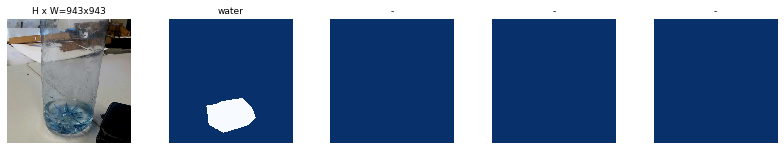

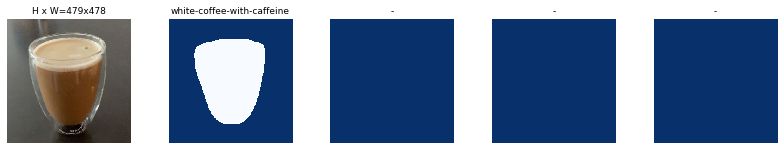

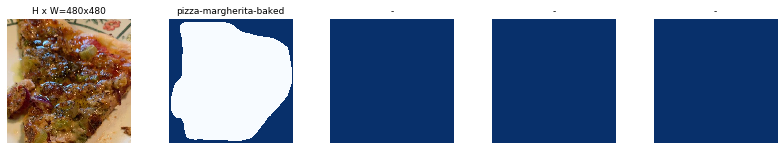

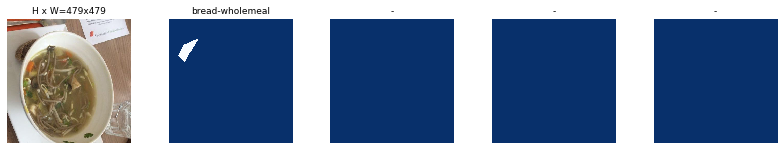

In [ ]:

image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Bounding Boxes

image_id  2567 crowdai-food-challenge::2567
image                    shape: (479, 480, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (479, 480, 2)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (2,)                  min:    3.00000  max:   12.00000  int32
bbox                     shape: (2, 4)                min:   23.00000  max:  440.00000  int32


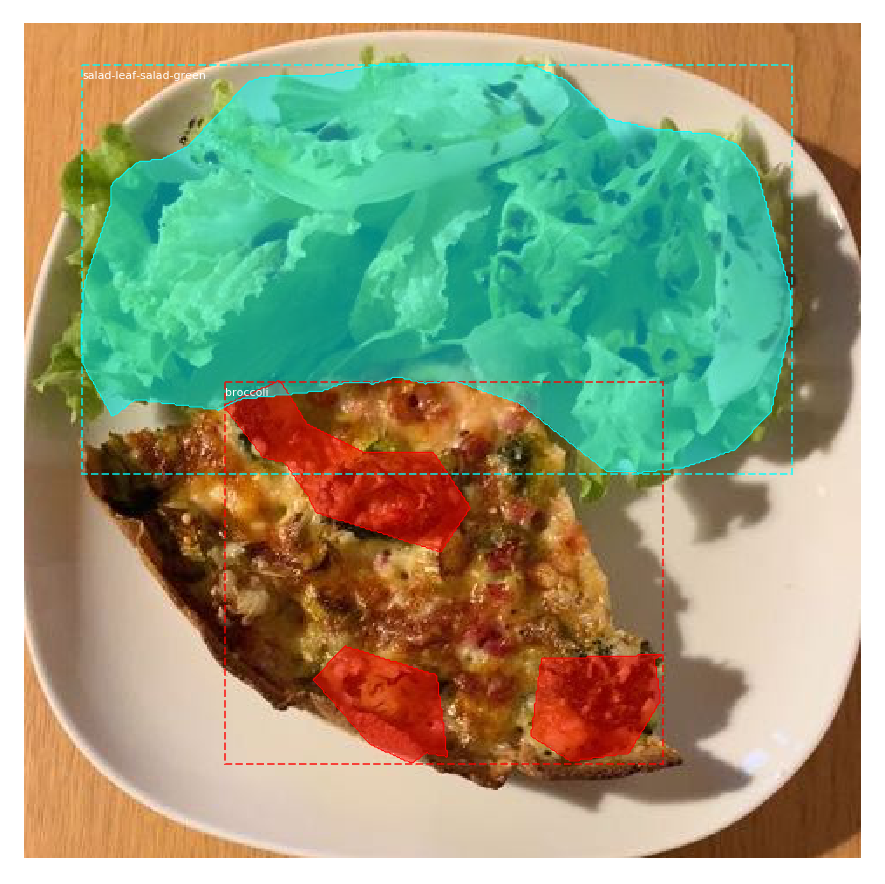

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Mini Masks
Read more at:
[mask rcnn mini mask](https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/inspect_data.ipynb)

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (53,)                 min:    1.00000  max: 5316.00000  float64
class_ids                shape: (2,)                  min:   12.00000  max:   27.00000  int32
bbox                     shape: (2, 4)                min:  135.00000  max:  907.00000  int32
mask                     shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8


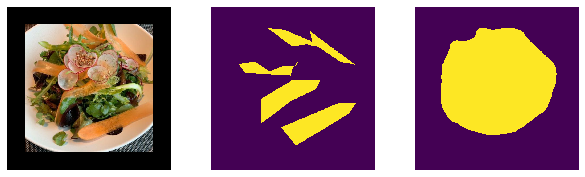

In [ ]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

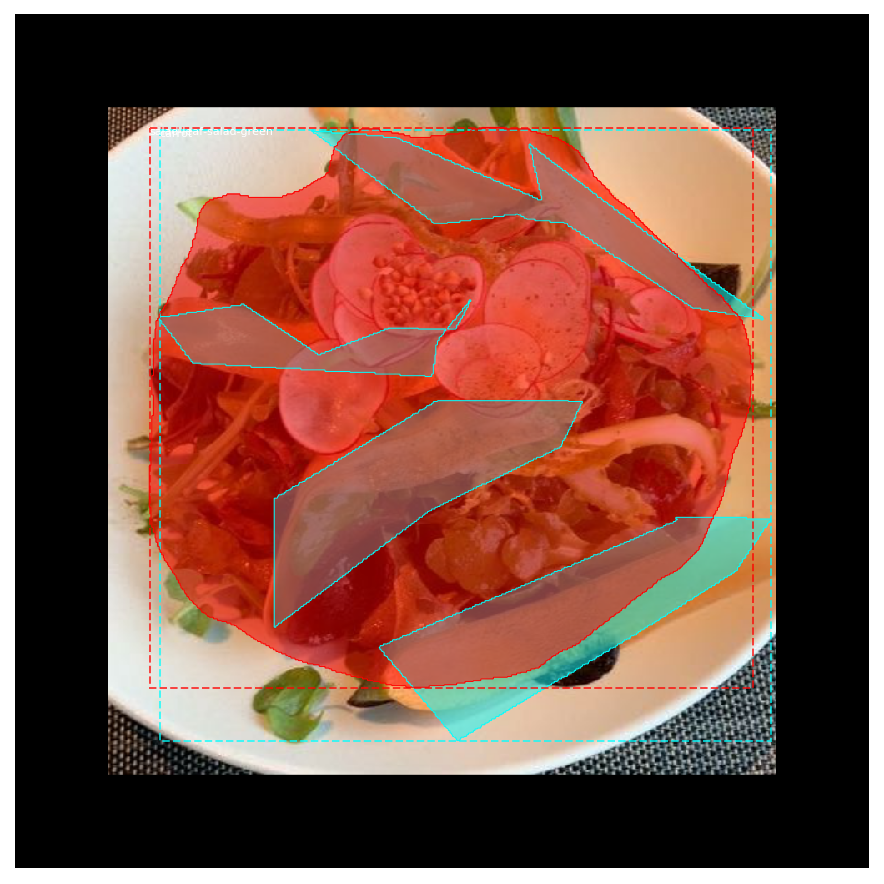

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 2)           min:    0.00000  max:    1.00000  bool


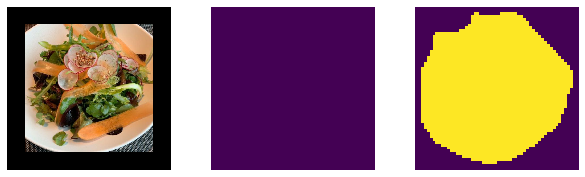

In [ ]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

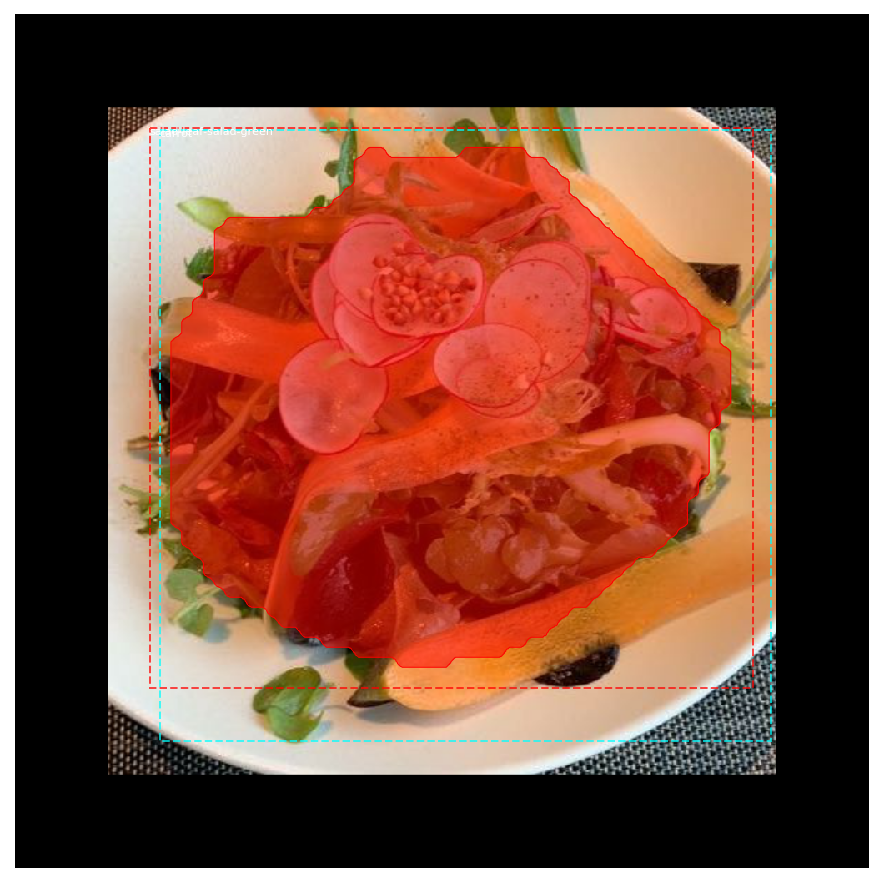

In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Anchors
Read more about anchors at: 
[Anchors Mask RCNN](https://medium.com/@alittlepain833/simple-understanding-of-mask-rcnn-134b5b330e95)

In [ ]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


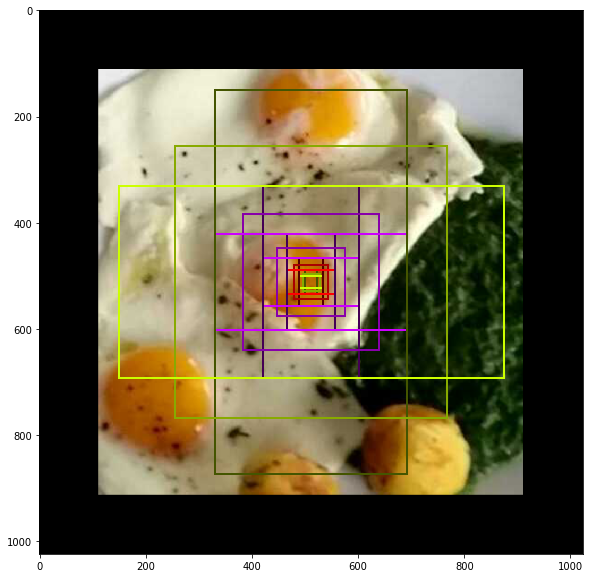

In [ ]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

In [ ]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [ ]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:   23.00000  int32
mrcnn_bbox               shape: (4, 200, 81, 4)       min:   -3.44609  max:    3.43504  float32
mrcnn_mask               shape: (4, 200, 28, 28, 81)  min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:   23.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  892.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -1.14258  max:    1.90207  float64
image_id:  996 crowdai-food-challenge::996


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (1, 4)                min:  143.00000  max:  892.00000  float32
Positive anchors: 1
Negative anchors: 255
Neutral anchors: 261632
BG                     : 134
mixed-vegetables       : 66


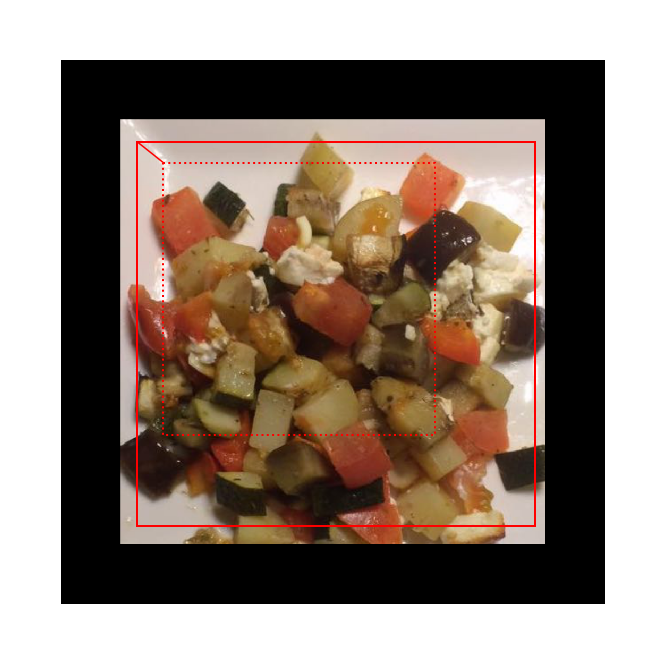

In [ ]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

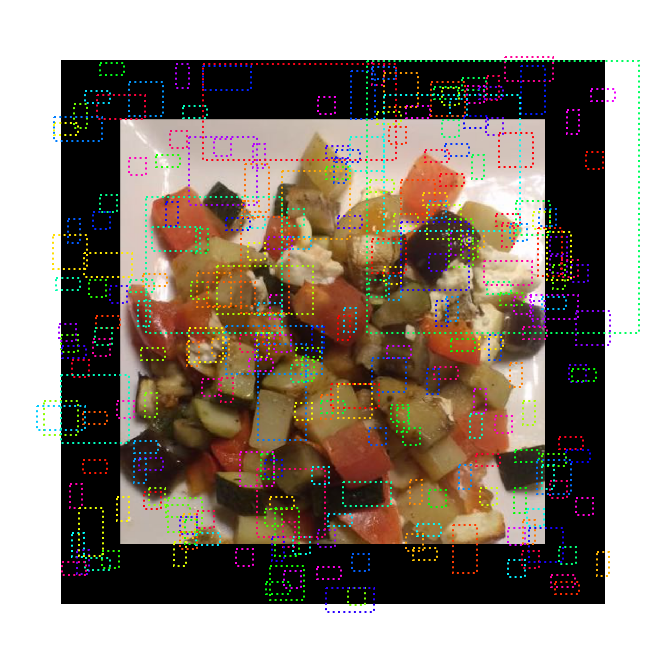

In [ ]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

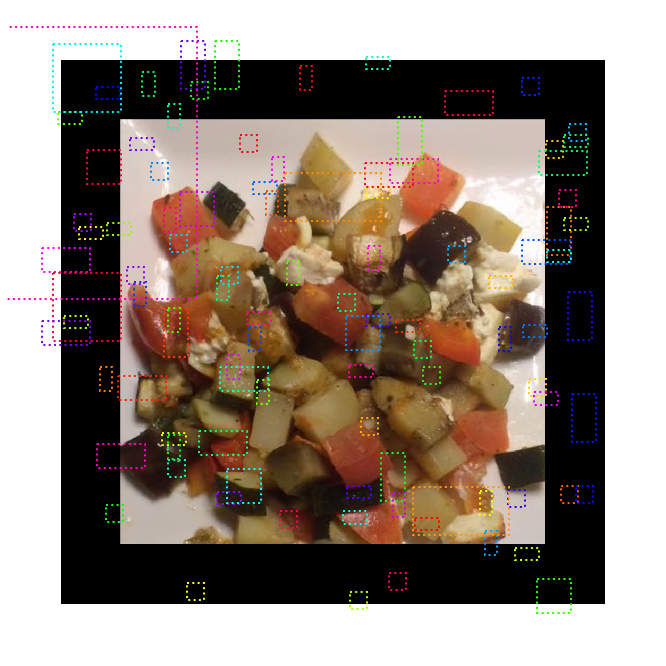

In [ ]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

# ROIs
More at: [ROI](https://medium.com/@fractaldle/mask-r-cnn-unmasked-c029aa2f1296)

Positive ROIs:  66
Negative ROIs:  134
Positive Ratio: 0.33
Unique ROIs: 200 out of 200


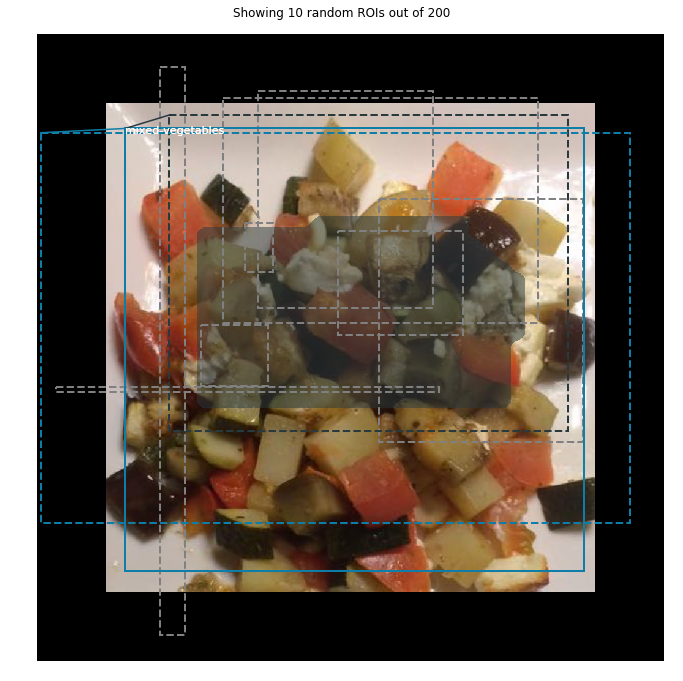

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

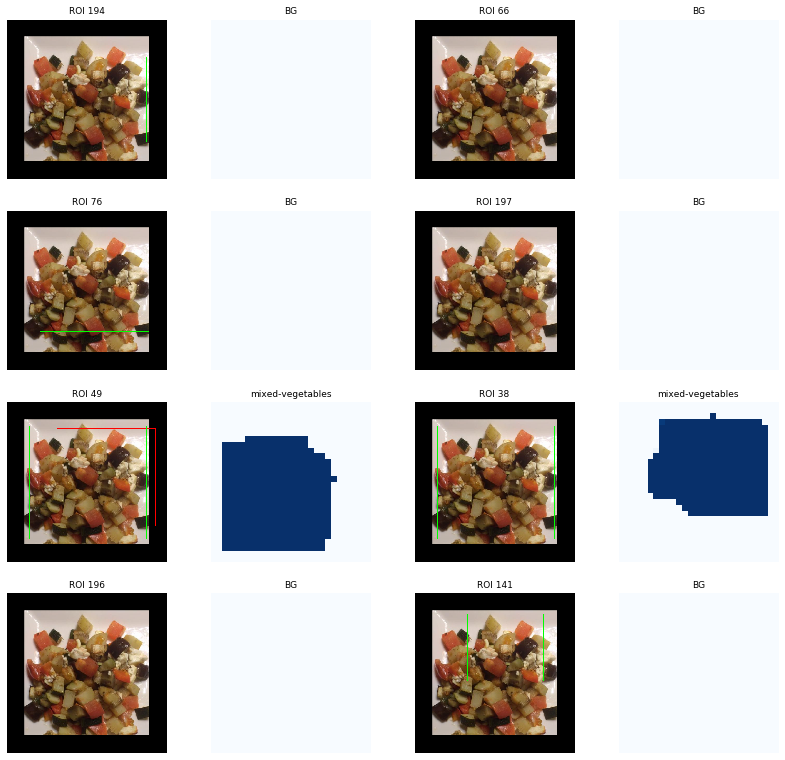

In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [ ]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


# Training the MaskRCNN model (Tensorflow):
Using the cloned repository - https://gitlab.aicrowd.com/nikhil_rayaprolu/food-recognition, follow the Installation instructions in the README and finally run
`python train.py`


You can make any further changes to the configuration and the model to build your own custom model.


# Locally Evaluating the model:
An example of Local evaluation is provided at: https://gitlab.aicrowd.com/nikhil_rayaprolu/food-recognition/blob/master/Eval_Local.ipynb

We provided the cocoeval.py that simplifies evaluating models on COCO formatted datasets.
On providing the ground truth and result annotations, one can get the Average Precision and Recall on the dataset.
```
from cocoeval import COCOeval
IMAGES_DIR = "data/val/images"
GROUND_TRUTH_ANNOTATION_PATH = "data/val/annotation.json"
ground_truth_annotations = COCO(GROUND_TRUTH_ANNOTATION_PATH)
results = ground_truth_annotations.loadRes(_final_object)
cocoEval = COCOeval(ground_truth_annotations, results, 'segm')
cocoEval.evaluate()
cocoEval.accumulate()
average_precision = cocoEval._summarize(ap=1, iouThr=0.5, areaRng="all", maxDets=100)
average_recall = cocoEval._summarize(ap=0, iouThr=0.5, areaRng="all", maxDets=100)
print("Average Precision : {} || Average Recall : {}".format(average_precision, average_recall))
```



# Submitting your pretrained model on AICrowd:
Let's first understand the submission process on AICrowd.

# Evaluation Criteria

For for a known ground truth mask **A**, you propose a mask **B**, then we first compute **IoU** (Intersection Over Union) :      

<img src="https://latex.codecogs.com/gif.latex?$$&space;IoU(A,&space;B)&space;=&space;\frac{A&space;\cap&space;B}{&space;A&space;\cup&space;B}&space;$$" title="$$ IoU(A, B) = \frac{A \cap B}{ A \cup B} $$" />

$$IoU$$ measures the overall overlap between the true region and the proposed region.
Then we consider it a True detection, when there is atleast half an overlap, or when **IoU > 0.5**

Then we can define the following parameters :

* Precision (**IoU > 0.5**)   
<img src="https://latex.codecogs.com/gif.latex?$$&space;P_{IoU&space;\geq&space;0.5}&space;=&space;\frac{TP_{IoU&space;\geq&space;0.5}}{TP_{IoU&space;\geq&space;0.5}&space;&plus;&space;FP_{IoU&space;\geq&space;0.5}}&space;$$" title="$$ P_{IoU \geq 0.5} = \frac{TP_{IoU \geq 0.5}}{TP_{IoU \geq 0.5} + FP_{IoU \geq 0.5}} $$" />

* Recall (**IoU > 0.5**)   
<img src="https://latex.codecogs.com/gif.latex?$$&space;R_{IoU&space;\geq&space;0.5}&space;=&space;\frac{TP_{IoU&space;\geq&space;0.5}}{TP_{IoU&space;\geq&space;0.5}&space;&plus;&space;FN_{IoU&space;\geq&space;0.5}}&space;$$." title="$$ R_{IoU \geq 0.5} = \frac{TP_{IoU \geq 0.5}}{TP_{IoU \geq 0.5} + FN_{IoU \geq 0.5}} $$." />

The final scoring parameters **AP_{IoU > 0.5}** and **AR_{IoU > 0.5}** are computed by averaging over all the precision and recall values for all known annotations in the ground truth.


# Submission Instructions

To submit to the challenge you'll need to ensure you've set up an appropriate repository structure, create a private git repository at https://gitlab.aicrowd.com with the contents of your submission, and push a git tag corresponding to the version of your repository you'd like to submit.

## Repository Structure
We have created this sample submission repository which you can use as reference.

#### aicrowd.json
Each repository should have a aicrowd.json file with the following fields:

```
{
    "challenge_id" : "aicrowd-food-recognition-challenge",
    "grader_id": "aicrowd-food-recognition-challenge",
    "authors" : ["aicrowd-user"],
    "description" : "Food Recognition Challenge Submission",
    "license" : "MIT",
    "gpu": false
}
```
This file is used to identify your submission as a part of the Snake Species Identification Challenge.  You must use the `challenge_id` and `grader_id` specified above in the submission. The `gpu` key in the `aicrowd.json` lets your specify if your submission requires a GPU or not. In which case, a NVIDIA-K80 will be made available to your submission when evaluation the submission.

#### Submission environment configuration
You can specify the software runtime of your code by modifying the included [Dockerfile](Dockerfile). 

#### Code Entrypoint
The evaluator will use `/home/aicrowd/run.sh` as the entrypoint. Please remember to have a `run.sh` at the root which can instantiate any necessary environment variables and execute your code. This repository includes a sample `run.sh` file.

### Local Debug

```
export TEST_IMAGES_PATH="./data/test_images"
export IMAGE_NAME="aicrowd-food-recognition-challenge-submission"

./build.sh
./debug.sh

######################################
## NOTE : 
## 
## * If you do not wish to your a GPU when testing locally, please feel free to replace nvidia-docker with docker
##
## * If you want to test on images located at an alternate location, set the `TEST_IMAGES_PATH` environment variable accordingly before running `build.sh` and `debug.sh`.
```

### Submitting 
To make a submission, you will have to create a private repository on [https://gitlab.aicrowd.com](https://gitlab.aicrowd.com).

You will have to add your SSH Keys to your GitLab account by following the instructions [here](https://docs.gitlab.com/ee/gitlab-basics/create-your-ssh-keys.html).
If you do not have SSH Keys, you will first need to [generate one](https://docs.gitlab.com/ee/ssh/README.html#generating-a-new-ssh-key-pair).

Then you can create a submission by making a *tag push* to your repository, adding the correct git remote and pushing to the remote:

```
git clone https://github.com/AIcrowd/food-recognition-challenge-starter-kit
cd food-recognition-challenge-starter-kit

# Add AICrowd git remote endpoint
git remote add aicrowd git@gitlab.aicrowd.com:<YOUR_AICROWD_USER_NAME>/food-recognition-challenge-starter-kit.git
git push aicrowd master

# Create a tag for your submission and push
git tag -am "submission-v0.1" submission-v0.1
git push aicrowd master
git push aicrowd submission-v0.1

# Note : If the contents of your repository (latest commit hash) does not change, 
# then pushing a new tag will not trigger a new evaluation.
```
You now should be able to see the details of your submission at : 
[gitlab.aicrowd.com/<YOUR_AICROWD_USER_NAME>/food-recognition-challenge-starter-kit/issues](gitlab.aicrowd.com/<YOUR_AICROWD_USER_NAME>/food-recognition-challenge-starter-kit/issues)




An example repository that has the structure required for submission is at https://gitlab.aicrowd.com/nikhil_rayaprolu/food-recognition

This repository contains [aicrowd.json](https://gitlab.aicrowd.com/nikhil_rayaprolu/food-recognition/blob/master/aicrowd.json)  and custom changes
to [Dockerfile](https://gitlab.aicrowd.com/nikhil_rayaprolu/food-recognition/blob/master/Dockerfile)
```
# Custom changes for Submission

COPY ./requirements.txt .
RUN pip install -r requirements.txt --user
COPY . .
```
changes to [run.py](https://gitlab.aicrowd.com/nikhil_rayaprolu/food-recognition/blob/master/run.py#L135) can be seen at line 135, where we call a function from [eval.py](https://gitlab.aicrowd.com/nikhil_rayaprolu/food-recognition/blob/master/eval.py#L82) .
 
run.py . 
```
evaluate(test_images_path, predictions_output_path)
```
Inside the evaluate function in [eval.py](https://gitlab.aicrowd.com/nikhil_rayaprolu/food-recognition/blob/master/eval.py#L102), we pass the images into the model for detection . 
eval.py . 
```
predoctions = model.detect(images, verbose=0)
```

By writing this code, we are basically allowing AICrowd Auto-Evaluators to pass private test data into your model and detect predictions in runtime
for the new data.





## Bonus
MMdetection is an open source object detection toolbox based on PyTorch, with a large Model Zoo with many customised models that can be plugged and tested in with just a single config file modification. PYou can read more about it at: [mmdetection github](https://github.com/open-mmlab/mmdetection/)

Follow the installation instructions as given in the above link.
# Training with MMDetection:
Let us look at training MMDetection using Hybrid Task Cascade [HTC research paper](https://arxiv.org/abs/1901.07518).

A score of AP_50 of 0.526	and AR_50 of 0.729, can be achieved with Hybrid Task Cascade of Resnet50 Backbone.

MMDetection provides us with a config file especially for HTC, available at [HTC config](https://github.com/open-mmlab/mmdetection/tree/master/configs/htc)

Also make sure you have downloaded the training data to a subfolder of your project.

Modify your config file and point your dataset variables to your data folder.

As given in [MMDetection Getting Started](https://github.com/open-mmlab/mmdetection/blob/master/docs/GETTING_STARTED.md),
You can use:

    python tools/train.py ${CONFIG_FILE}
to train the model on a single GPU or

    ./tools/dist_train.sh ${CONFIG_FILE} ${GPU_NUM} [optional arguments]
to train the model on multiple GPUs.

Make sure you have edited the config file to point to the dataset and also have made changes to the number of classes.
If you are going to use the dataloader from the mmdetection.

## Testing with MMDetection:
To test your results with MMDetection, 
you can use the commands:
```
*single-gpu testing*
python tools/test.py ${CONFIG_FILE} ${CHECKPOINT_FILE} [--out ${RESULT_FILE}] [--eval ${EVAL_METRICS}] [--show]

*multi-gpu testing*
./tools/dist_test.sh ${CONFIG_FILE} ${CHECKPOINT_FILE} ${GPU_NUM} [--out ${RESULT_FILE}] [--eval ${EVAL_METRICS}]
```

**Log Analysis**

The training logs can be analyzed using the plot_curve provided with the mmdetection:

```
import os
import matplotlib
%matplotlib inline
from tools.analyze_logs import plot_curve
matplotlib.rcParams['figure.figsize'] = [20, 10]
args = {
    'keys':['segm_mAP_50'],
    'legend':'segm_mAP_50',
    'backend': None,
    'json_logs': [os.getcwd()+'/work_dirs/htc_r50_fpn/20191206_105437.log.json'],
    'title': 'loss'
}
print(os.getcwd()+'/work_dirs/htc_r50_fpn/20191206_105437.log.json')
plot_curve([os.getcwd()+'/work_dirs/htc_r50_fpn/20191206_105437.log.json'], args)
```


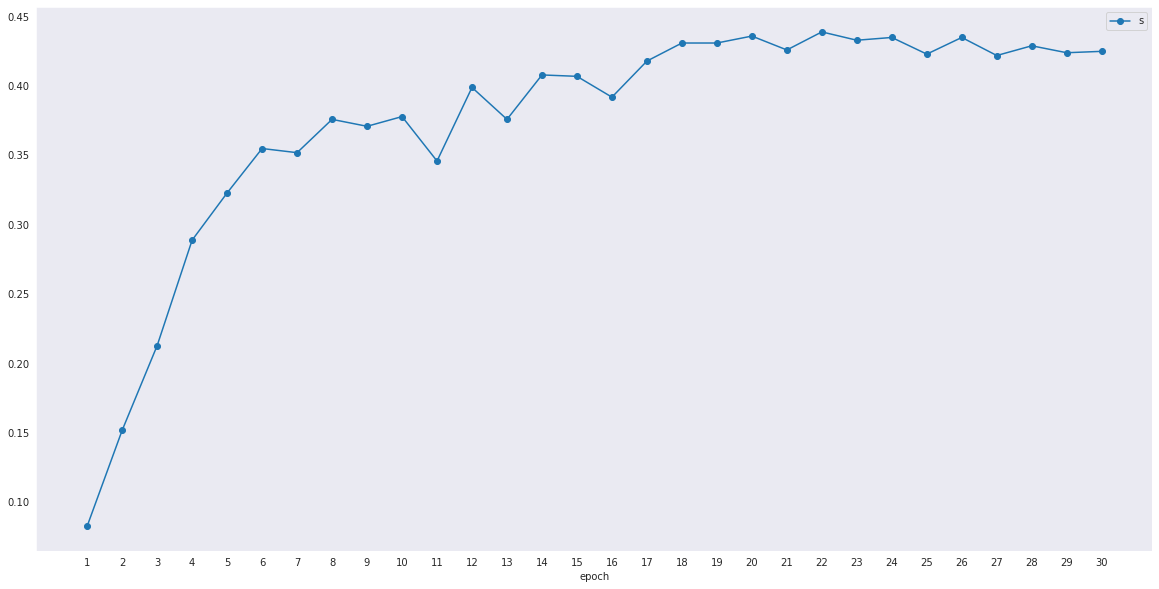

# **Results**

We can use the low level inference modules provided with MMDetection to produce results from the trained model

In [13]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 11955, done.
remote: Total 11955 (delta 0), reused 0 (delta 0), pack-reused 11955
Receiving objects: 100% (11955/11955), 9.36 MiB | 6.38 MiB/s, done.
Resolving deltas: 100% (8165/8165), done.


In [14]:
%cd mmdetection

/content/food-recognition/mmdetection


In [15]:
!pip install -r requirements/build.txt
!pip install "git+https://github.com/open-mmlab/cocoapi.git#subdirectory=pycocotools"

  Cloning https://github.com/open-mmlab/cocoapi.git to /tmp/pip-req-build-whdokdjn
  Running command git clone -q https://github.com/open-mmlab/cocoapi.git /tmp/pip-req-build-whdokdjn
  Created wheel for pycocotools: filename=pycocotools-12.0-cp36-cp36m-linux_x86_64.whl size=267282 sha256=1107c8272284c55317deb0f6b61f8a9e0e1d0f1efa9aa979fee6c726fbcf1229
  Stored in directory: /tmp/pip-ephem-wheel-cache-_t1a3rxk/wheels/cd/f6/de/018ccc2d175046c612e93b42a169cd1ab7563d61581cfba8df
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1


In [16]:
!pip install -v -e .  # or "python setup.py develop"

Created temporary directory: /tmp/pip-ephem-wheel-cache-54xb5c8k
Created temporary directory: /tmp/pip-req-tracker-14yzu07q
Created requirements tracker '/tmp/pip-req-tracker-14yzu07q'
Created temporary directory: /tmp/pip-install-_lac8lui
Obtaining file:///content/food-recognition/mmdetection
  Added file:///content/food-recognition/mmdetection to build tracker '/tmp/pip-req-tracker-14yzu07q'
    Running setup.py (path:/content/food-recognition/mmdetection/setup.py) egg_info for package from file:///content/food-recognition/mmdetection
    Running command python setup.py egg_info
    running egg_info
    creating mmdet.egg-info
    writing mmdet.egg-info/PKG-INFO
    writing dependency_links to mmdet.egg-info/dependency_links.txt
    writing requirements to mmdet.egg-info/requires.txt
    writing top-level names to mmdet.egg-info/top_level.txt
    writing manifest file 'mmdet.egg-info/SOURCES.txt'
    writing manifest file 'mmdet.egg-info/SOURCES.txt'
    /usr/local/lib/python3.6/dist

In [14]:
import coco
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5
    NUM_CLASSES = 41  # 1 Background + 1 Building
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "crowdai-mapping-challenge"
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                53
IMAGE_MIN_DIM                  320
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-mapping-challenge
NUM_CLASSES                    41
POOL_SIZE                      7
POST_NMS_ROIS_INFEREN

In [15]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

model = init_detector('configs/cityscapes/faster_rcnn_r50_fpn_1x_coco.py',
                      'configs/cityscapes/faster_rcnn_r50_fpn_1x_20181010-3d1b3351.pth', device='cuda:0')
# test a single image and show the results
img = '/ssd_scratch/cvit/nikhilnew/crowd/data/test_images/011309.jpg'  # or img = mmcv.imread(img), which will only load it once
result = inference_detector(model, img)
# visualize the results in a new window
show_result_pyplot(img, result, categories)


ImportError: ignored

In [16]:
%debug

> /usr/local/lib/python3.6/dist-packages/PIL/ImageOps.py(24)<module>()
     22 
     23 from . import Image
---> 24 from ._util import isStringType
     25 
     26 #

ipdb> up
> <frozen importlib._bootstrap>(219)_call_with_frames_removed()

ipdb> up
> <frozen importlib._bootstrap_external>(678)exec_module()

ipdb> up
> <frozen importlib._bootstrap>(665)_load_unlocked()

ipdb> up
> <frozen importlib._bootstrap>(955)_find_and_load_unlocked()

ipdb> up
> <frozen importlib._bootstrap>(971)_find_and_load()

ipdb> up
> <frozen importlib._bootstrap>(219)_call_with_frames_removed()

ipdb> up
> <frozen importlib._bootstrap>(1031)_handle_fromlist()

ipdb> up
> /usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py(3)<module>()
      1 import torch
      2 import math
----> 3 from PIL import Image, ImageOps, ImageEnhance, __version__ as PILLOW_VERSION
      4 try:
      5     import accimage

ipdb> up
> <frozen importlib._bootstrap>(219)_call_with_frames_removed()

ipdb> up


In [20]:
!python tools/train.py configs/htc/htc_r101_fpn_20e_coco.py

2020-07-05 15:49:55,563 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.6.9 (default, Apr 18 2020, 01:56:04) [GCC 8.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.1, V10.1.243
GPU 0: Tesla T4
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.5.1+cu101
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=co

In [18]:
!python tools/train.py ../mrcnn/config.py

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/yapf/yapflib/pytree_utils.py", line 115, in ParseCodeToTree
    tree = parser_driver.parse_string(code, debug=False)
  File "/usr/lib/python3.6/lib2to3/pgen2/driver.py", line 107, in parse_string
    return self.parse_tokens(tokens, debug)
  File "/usr/lib/python3.6/lib2to3/pgen2/driver.py", line 72, in parse_tokens
    if p.addtoken(type, value, (prefix, start)):
  File "/usr/lib/python3.6/lib2to3/pgen2/parse.py", line 159, in addtoken
    raise ParseError("bad input", type, value, context)
lib2to3.pgen2.parse.ParseError: bad input: type=20, value='<', context=('', (1, 5))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/yapf/yapflib/pytree_utils.py", line 121, in ParseCodeToTree
    tree = parser_driver.parse_string(code, debug=False)
  File "/usr/lib/python3.6/lib2to3/pgen2/driver.py", line 107, in pa

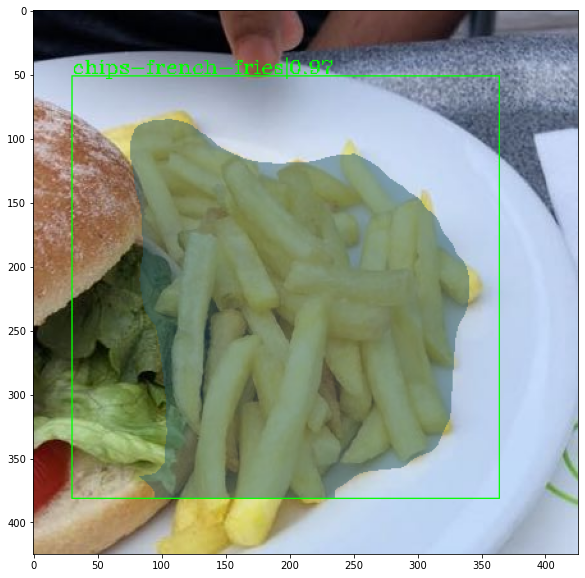

In [ ]:
img = '/ssd_scratch/cvit/nikhilnew/crowd/data/test_images/035944.jpg'  # or img = mmcv.imread(img), which will only load it once
result = inference_detector(model, img)
# visualize the results in a new window
show_result_pyplot(img, result, categories)

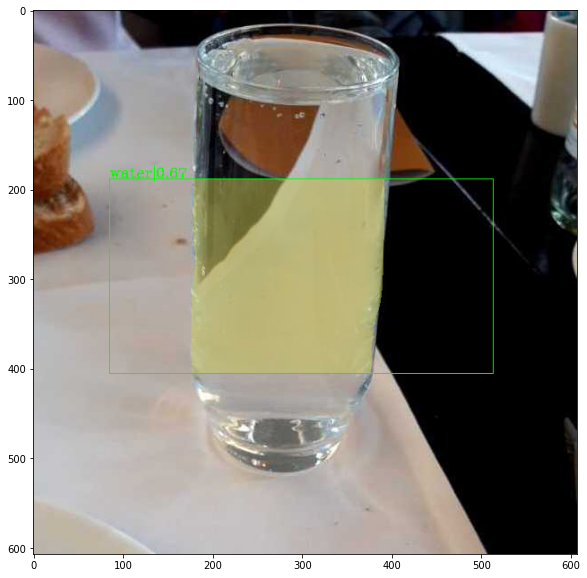

In [ ]:
img = '/ssd_scratch/cvit/nikhilnew/crowd/data/test_images/014933.jpg'  # or img = mmcv.imread(img), which will only load it once
result = inference_detector(model, img)
# visualize the results in a new window
show_result_pyplot(img, result, categories)

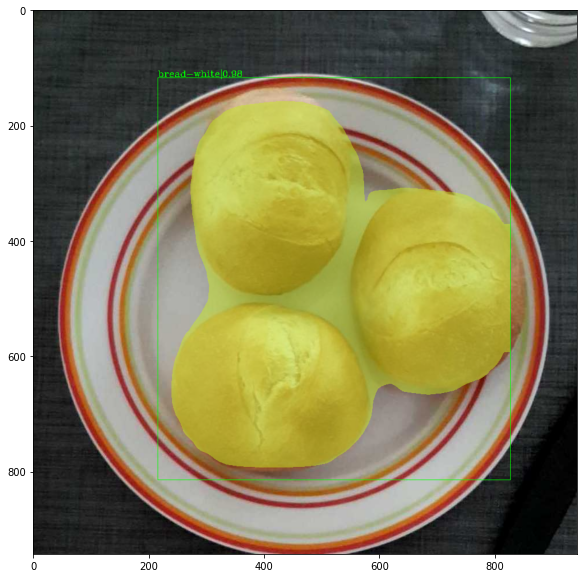

In [ ]:
result = inference_detector(model, img)
# visualize the results in a new window
show_result_pyplot(img, result, categories)

# Tips
* Make sure you go through the config file, modify the number of classes.
* To achieve higher scores, you could try various data augmentation techniques, parameter tuning, other test time augmentations possible.
* You can go through [Kaggle Imaterialist Top solution](https://github.com/amirassov/kaggle-imaterialist) and [mmdetection mask rcnnn with albumentations](https://github.com/open-mmlab/mmdetection/blob/master/configs/albu_example/mask_rcnn_r50_fpn_1x.py) to understand other ways to make a.



We Credit https://github.com/matterport/Mask_RCNN for providing the MaskRCNN library and extensive tutorials around Instance segmentation, and https://github.com/open-mmlab/mmdetection/ for building a highly extensible and active library around instance segmentation